# Flair NLP Framework

In [1]:
!pip install --upgrade flair==0.11.1
!pip install torch
!pip install importlib-metadata
!pip install emoji
!pip install nltk
!pip install sacremoses


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 401 kB 34.1 MB/s 
     |████████████████████████████████| 1.6 MB 50.6 MB/s 
     |████████████████████████████████| 46 kB 850 kB/s 
     |████████████████████████████████| 48 kB 6.0 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 120 kB 70.0 MB/s 
     |████████████████████████████████| 19.7 MB 420 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 981 kB 58.5 MB/s 
     |████████████████████████████████| 788 kB 68.7 MB/s 
     |████████████████████████████████| 1.2 MB 55.0 MB/s 
     |████████████████████████████████| 4.7 MB 58.2 MB/s 
     |████████████████████████████████| 200 kB 74.7 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |███████████████████████

In [2]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import time
import joblib
from flair.data import Corpus, Sentence
from flair.datasets import ClassificationCorpus, CSVClassificationCorpus, TREC_6
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentLSTMEmbeddings, TransformerDocumentEmbeddings, StackedEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.visual.training_curves import Plotter
from flair.hyperparameter.param_selection import SearchSpace, Parameter
from flair.hyperparameter.param_selection import TextClassifierParamSelector, OptimizationValue
from hyperopt import hp
from pathlib import Path
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from typing import List

from google.colab import drive
drive.mount('/content/drive')

import torch
from torch.optim.adam import Adam
torch.cuda.is_available()


Mounted at /content/drive


True

# Paths

In [3]:
# Parent paths
google_path = '/content/drive/My Drive/'
local_path = '/home/v.zevallosm/'
parent_path = google_path

#Specific paths
path_corpus = parent_path+"team project/data set/dataset search/twitter_and_cyberbullying/data.csv"  

path_flair = parent_path+"team project/data set/dataset search/twitter_and_cyberbullying/flair_shape/"
path_flair_train = path_flair+"train.csv"
path_flair_dev = path_flair+"dev.csv"
path_flair_test = path_flair+"test.csv"

path_model_distilbert = parent_path+"team project/codes/models/flair_models/twitter_cyberbullying_distilbert_final"
path_model_distilroberta = parent_path+"team project/codes/models/flair_models/twitter_cyberbullying_distilroberta_final"


# Data Exploration

,tweet,label
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0
4,@RudhoeEnglish This is an ISIS account pretend...,0


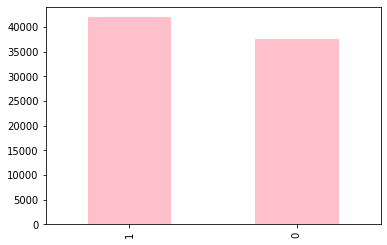

In [4]:
data = pd.read_csv(path_corpus)

data['label'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))
data.head()

# Fast text format and split Dataset

In [5]:
data['label'] = '__label__' + data['label'].astype(str)

train, test = train_test_split(data, test_size=0.2, random_state = 453, stratify=data['label'])
test, dev = train_test_split(test, test_size=0.5 , random_state = 453, stratify= test['label'])

train.to_csv(path_flair_train, sep='\t', index = False, header = False)
test.to_csv(path_flair_test, sep='\t', index = False, header = False)
dev.to_csv(path_flair_dev, sep='\t', index = False, header = False)

train.head(5)

,tweet,label
21782,@DianH4 @ExposeFalsehood .....80% of Afghan ci...,__label__1
28378,Having a high level of toxicity in your commun...,__label__1
33213,I started school in Darwin 1971...Cheesy warm ...,__label__1
59425,this is what #waiting at 2:30am for the shuttl...,__label__0
52405,home sweet second home... #vegas #girltime #d...,__label__0


# Train Classifier

## Distilbert

In [6]:
#1. get the corpus
column_name_map = {0: "text", 1: "label_topic"}
corpus: Corpus = CSVClassificationCorpus(path_flair,
                                         column_name_map,
                                         skip_header=True,
                                         delimiter='\t',   # tab-separated files
                                         label_type= "label")
print(corpus)

#2. what label do we want to predict?
label_type = 'label'

# 3. create the label dictionary
label_dict = corpus.make_label_dictionary(label_type=label_type)

# 4. initialize transformer document embeddings (many models are available)
document_embeddings = TransformerDocumentEmbeddings('distilbert-base-uncased', fine_tune=True)

# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict, label_type=label_type)

# 6. initialize trainer
trainer = ModelTrainer(classifier, corpus)

2022-08-24 16:39:24,820 Reading data from /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape
2022-08-24 16:39:24,821 Train: /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape/train.csv
2022-08-24 16:39:24,822 Dev: /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape/dev.csv
2022-08-24 16:39:24,824 Test: /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape/test.csv
Corpus: 63722 train + 7965 dev + 7964 test sentences
2022-08-24 16:39:25,354 Computing label dictionary. Progress:


63722it [00:43, 1477.89it/s]

2022-08-24 16:40:08,532 Dictionary created for label 'label' with 3 values: __label__1 (seen 33590 times), __label__0 (seen 30132 times)


In [10]:
# 7. run training with fine-tuning
trainer.fine_tune(path_model_distilbert,
                  learning_rate=5.0e-5,
                  mini_batch_size=4,
                  max_epochs=4,
                  write_weights = True, #maybe
                  )


2022-08-24 16:45:20,499 ----------------------------------------------------------------------------------------------------
2022-08-24 16:45:20,504 Model: "TextClassifier(
  (decoder): Linear(in_features=768, out_features=3, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (locked_dropout): LockedDropout(p=0.0)
  (word_dropout): WordDropout(p=0.0)
  (loss_function): CrossEntropyLoss()
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_featur

100%|██████████| 1992/1992 [00:21<00:00, 92.16it/s]

2022-08-24 17:00:30,559 Evaluating as a multi-label problem: False


2022-08-24 17:00:30,621 DEV : loss 0.058838263154029846 - f1-score (micro avg)  0.9026
2022-08-24 17:00:34,592 BAD EPOCHS (no improvement): 4
2022-08-24 17:00:34,599 ----------------------------------------------------------------------------------------------------
2022-08-24 17:02:00,132 epoch 2 - iter 1593/15931 - loss 0.04914645 - samples/sec: 76.86 - lr: 0.000040
2022-08-24 17:03:28,679 epoch 2 - iter 3186/15931 - loss 0.04961280 - samples/sec: 76.80 - lr: 0.000039
2022-08-24 17:04:57,414 epoch 2 - iter 4779/15931 - loss 0.05003801 - samples/sec: 76.63 - lr: 0.000038
2022-08-24 17:06:25,857 epoch 2 - iter 6372/15931 - loss 0.04963533 - samples/sec: 76.89 - lr: 0.000036
2022-08-24 17:07:54,368 epoch 2 - iter 7965/15931 - loss 0.04988483 - samples/sec: 76.87 - lr: 0.000035
2022-08-24 17:09:23,087 epoch 2 - iter 9558/15931 - loss 0.05023422 - samples/sec: 77.26 - lr: 0.000033
2022-08-24 17:10:51,476 epoch 2 - iter 11151/15931 - loss 0.05026350 - samples/sec: 76.95 - lr: 0.000032
2022

100%|██████████| 1992/1992 [00:21<00:00, 93.39it/s]

2022-08-24 17:15:40,303 Evaluating as a multi-label problem: False


2022-08-24 17:15:40,362 DEV : loss 0.054471876472234726 - f1-score (micro avg)  0.911
2022-08-24 17:15:44,034 BAD EPOCHS (no improvement): 4
2022-08-24 17:15:44,040 ----------------------------------------------------------------------------------------------------
2022-08-24 17:17:10,043 epoch 3 - iter 1593/15931 - loss 0.03683469 - samples/sec: 76.92 - lr: 0.000026
2022-08-24 17:18:38,009 epoch 3 - iter 3186/15931 - loss 0.03796173 - samples/sec: 77.10 - lr: 0.000025
2022-08-24 17:20:06,298 epoch 3 - iter 4779/15931 - loss 0.03869909 - samples/sec: 76.84 - lr: 0.000024
2022-08-24 17:21:34,482 epoch 3 - iter 6372/15931 - loss 0.03790907 - samples/sec: 77.09 - lr: 0.000022
2022-08-24 17:23:03,008 epoch 3 - iter 7965/15931 - loss 0.03792749 - samples/sec: 76.69 - lr: 0.000021
2022-08-24 17:24:31,011 epoch 3 - iter 9558/15931 - loss 0.03787560 - samples/sec: 77.16 - lr: 0.000019
2022-08-24 17:25:59,256 epoch 3 - iter 11151/15931 - loss 0.03781928 - samples/sec: 77.11 - lr: 0.000018
2022-

100%|██████████| 1992/1992 [00:20<00:00, 95.33it/s]

2022-08-24 17:30:48,346 Evaluating as a multi-label problem: False


2022-08-24 17:30:48,404 DEV : loss 0.06768754124641418 - f1-score (micro avg)  0.9106
2022-08-24 17:30:52,327 BAD EPOCHS (no improvement): 4
2022-08-24 17:30:52,335 ----------------------------------------------------------------------------------------------------
2022-08-24 17:32:18,049 epoch 4 - iter 1593/15931 - loss 0.02824056 - samples/sec: 76.76 - lr: 0.000013
2022-08-24 17:33:46,838 epoch 4 - iter 3186/15931 - loss 0.02841158 - samples/sec: 76.92 - lr: 0.000011
2022-08-24 17:35:15,417 epoch 4 - iter 4779/15931 - loss 0.02725199 - samples/sec: 76.61 - lr: 0.000010
2022-08-24 17:36:43,521 epoch 4 - iter 6372/15931 - loss 0.02705712 - samples/sec: 77.03 - lr: 0.000008
2022-08-24 17:38:12,080 epoch 4 - iter 7965/15931 - loss 0.02654845 - samples/sec: 76.84 - lr: 0.000007
2022-08-24 17:39:40,019 epoch 4 - iter 9558/15931 - loss 0.02669262 - samples/sec: 77.12 - lr: 0.000006
2022-08-24 17:41:08,270 epoch 4 - iter 11151/15931 - loss 0.02656569 - samples/sec: 76.91 - lr: 0.000004
2022-

100%|██████████| 1992/1992 [00:21<00:00, 93.99it/s]

2022-08-24 17:45:56,708 Evaluating as a multi-label problem: False
2022-08-24 17:45:56,764 DEV : loss 0.08398918062448502 - f1-score (micro avg)  0.9086


2022-08-24 17:46:00,718 BAD EPOCHS (no improvement): 4
2022-08-24 17:46:01,682 ----------------------------------------------------------------------------------------------------
2022-08-24 17:46:01,688 Testing using last state of model ...


100%|██████████| 1991/1991 [00:21<00:00, 91.56it/s]


2022-08-24 17:46:23,480 Evaluating as a multi-label problem: False
2022-08-24 17:46:23,539 0.9131	0.9131	0.9131	0.9131
2022-08-24 17:46:23,541 
Results:
- F-score (micro) 0.9131
- F-score (macro) 0.9127
- Accuracy 0.9131

By class:
              precision    recall  f1-score   support

  __label__1     0.9068    0.9309    0.9187      4199
  __label__0     0.9206    0.8932    0.9067      3765

    accuracy                         0.9131      7964
   macro avg     0.9137    0.9121    0.9127      7964
weighted avg     0.9133    0.9131    0.9130      7964

2022-08-24 17:46:23,544 ----------------------------------------------------------------------------------------------------


{'test_score': 0.9131089904570567,
 'dev_score_history': [0.9025737602008789,
  0.9109855618330195,
  0.9106089139987446,
  0.908600125549278],
 'train_loss_history': [0.07038508510332744,
  0.04937631038693409,
  0.03730732017177353,
  0.02637299905823362],
 'dev_loss_history': [0.058838263154029846,
  0.054471876472234726,
  0.06768754124641418,
  0.08398918062448502]}

2022-08-24 17:55:48,571 ----------------------------------------------------------------------------------------------------
2022-08-24 17:55:48,576 WARNING: No LOSS found for test split in this data.
2022-08-24 17:55:48,578 Are you sure you want to plot LOSS and not another value?
2022-08-24 17:55:48,583 ----------------------------------------------------------------------------------------------------
2022-08-24 17:55:48,610 ----------------------------------------------------------------------------------------------------
2022-08-24 17:55:48,611 WARNING: No F1 found for test split in this data.
2022-08-24 17:55:48,612 Are you sure you want to plot F1 and not another value?
2022-08-24 17:55:48,618 ----------------------------------------------------------------------------------------------------
2022-08-24 17:55:50,463 Loss and F1 plots are saved in /content/drive/My Drive/team project/codes/models/flair_models/twitter_cyberbullying_distilbert_maybe/training.png


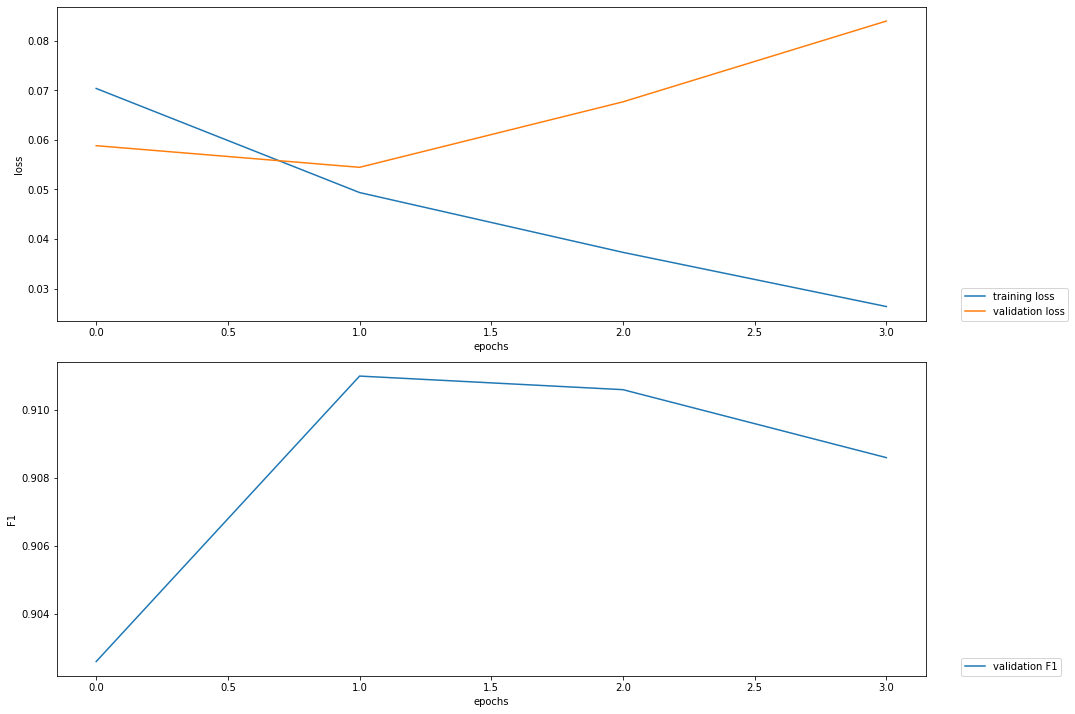

2022-08-24 17:56:09,863 Weights plots are saved in /content/drive/My Drive/team project/codes/models/flair_models/twitter_cyberbullying_distilbert_maybe/weights.png


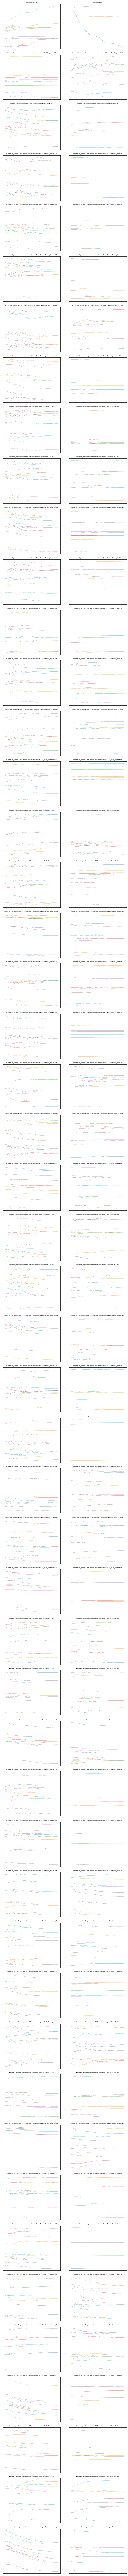

In [11]:
# visualize
plotter = Plotter()
plotter.plot_training_curves(path_model_distilbert+'/loss.tsv')
plotter.plot_weights(path_model_distilbert+'/weights.txt')

In [12]:
new_clf = TextClassifier.load(path_model_distilbert+'/final-model.pt')

2022-08-24 17:56:13,549 loading file /content/drive/My Drive/team project/codes/models/flair_models/twitter_cyberbullying_distilbert_maybe/final-model.pt


In [13]:
pred1 = Sentence("That girl is stupid")
pred2 = Sentence("This is a good material")

In [14]:
new_clf.predict(pred1)

In [15]:
pred1

Sentence: "That girl is stupid" → __label__1 (0.9984)

In [16]:
pred1.labels[0].to_dict()['value'] 

'__label__1'

## Distilroberta

In [17]:
#1. get the corpus
column_name_map = {0: "text", 1: "label_topic"}
corpus: Corpus = CSVClassificationCorpus(path_flair,
                                         column_name_map,
                                         skip_header=True,
                                         delimiter='\t',   # tab-separated files
                                         label_type= "label")
print(corpus)

#2. what label do we want to predict?
label_type = 'label'

# 3. create the label dictionary
label_dict = corpus.make_label_dictionary(label_type=label_type)

# 4. initialize transformer document embeddings (many models are available)
document_embeddings = TransformerDocumentEmbeddings('distilroberta-base', fine_tune=True)

# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict, label_type=label_type)

# 6. initialize trainer
trainer = ModelTrainer(classifier, corpus)

2022-08-24 17:56:29,644 Reading data from /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape
2022-08-24 17:56:29,646 Train: /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape/train.csv
2022-08-24 17:56:29,647 Dev: /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape/dev.csv
2022-08-24 17:56:29,649 Test: /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape/test.csv
Corpus: 63722 train + 7965 dev + 7964 test sentences
2022-08-24 17:56:30,283 Computing label dictionary. Progress:


63722it [00:30, 2115.01it/s]

2022-08-24 17:57:00,422 Dictionary created for label 'label' with 3 values: __label__1 (seen 33590 times), __label__0 (seen 30132 times)


In [18]:
# 7. run training with fine-tuning
trainer.fine_tune(path_model_distilroberta,
                  learning_rate=5.0e-5,
                  mini_batch_size=4,
                  max_epochs=4,
                  write_weights = True, #maybe
                  )


2022-08-24 17:59:10,035 ----------------------------------------------------------------------------------------------------
2022-08-24 17:59:10,039 Model: "TextClassifier(
  (decoder): Linear(in_features=768, out_features=3, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (locked_dropout): LockedDropout(p=0.0)
  (word_dropout): WordDropout(p=0.0)
  (loss_function): CrossEntropyLoss()
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAt

100%|██████████| 1992/1992 [00:21<00:00, 91.58it/s]

2022-08-24 18:16:29,077 Evaluating as a multi-label problem: False
2022-08-24 18:16:29,139 DEV : loss 0.0620226114988327 - f1-score (micro avg)  0.9033


2022-08-24 18:16:33,179 BAD EPOCHS (no improvement): 4
2022-08-24 18:16:33,189 ----------------------------------------------------------------------------------------------------
2022-08-24 18:18:11,854 epoch 2 - iter 1593/15931 - loss 0.05579203 - samples/sec: 66.38 - lr: 0.000040
2022-08-24 18:19:53,387 epoch 2 - iter 3186/15931 - loss 0.05684054 - samples/sec: 66.28 - lr: 0.000039
2022-08-24 18:21:35,236 epoch 2 - iter 4779/15931 - loss 0.05776187 - samples/sec: 66.19 - lr: 0.000038
2022-08-24 18:23:16,562 epoch 2 - iter 6372/15931 - loss 0.05834890 - samples/sec: 66.49 - lr: 0.000036
2022-08-24 18:24:57,735 epoch 2 - iter 7965/15931 - loss 0.05802799 - samples/sec: 66.56 - lr: 0.000035
2022-08-24 18:26:39,632 epoch 2 - iter 9558/15931 - loss 0.05738678 - samples/sec: 66.57 - lr: 0.000033
2022-08-24 18:28:21,266 epoch 2 - iter 11151/15931 - loss 0.05676602 - samples/sec: 66.25 - lr: 0.000032
2022-08-24 18:30:02,531 epoch 2 - iter 12744/15931 - loss 0.05662347 - samples/sec: 66.52 -

100%|██████████| 1992/1992 [00:21<00:00, 90.67it/s]

2022-08-24 18:33:50,726 Evaluating as a multi-label problem: False
2022-08-24 18:33:50,780 DEV : loss 0.05917101725935936 - f1-score (micro avg)  0.9104


2022-08-24 18:33:54,498 BAD EPOCHS (no improvement): 4
2022-08-24 18:33:54,507 ----------------------------------------------------------------------------------------------------
2022-08-24 18:35:33,545 epoch 3 - iter 1593/15931 - loss 0.04910002 - samples/sec: 66.15 - lr: 0.000026
2022-08-24 18:37:14,864 epoch 3 - iter 3186/15931 - loss 0.04750778 - samples/sec: 66.53 - lr: 0.000025
2022-08-24 18:38:58,116 epoch 3 - iter 4779/15931 - loss 0.04627250 - samples/sec: 65.70 - lr: 0.000024
2022-08-24 18:40:40,768 epoch 3 - iter 6372/15931 - loss 0.04567641 - samples/sec: 65.74 - lr: 0.000022
2022-08-24 18:42:23,586 epoch 3 - iter 7965/15931 - loss 0.04557711 - samples/sec: 65.61 - lr: 0.000021
2022-08-24 18:44:06,896 epoch 3 - iter 9558/15931 - loss 0.04537281 - samples/sec: 65.52 - lr: 0.000019
2022-08-24 18:45:49,511 epoch 3 - iter 11151/15931 - loss 0.04485974 - samples/sec: 65.71 - lr: 0.000018
2022-08-24 18:47:32,515 epoch 3 - iter 12744/15931 - loss 0.04465059 - samples/sec: 65.51 -

100%|██████████| 1992/1992 [00:22<00:00, 89.47it/s]

2022-08-24 18:51:23,676 Evaluating as a multi-label problem: False


2022-08-24 18:51:23,738 DEV : loss 0.06419095396995544 - f1-score (micro avg)  0.9141
2022-08-24 18:51:27,779 BAD EPOCHS (no improvement): 4
2022-08-24 18:51:27,788 ----------------------------------------------------------------------------------------------------
2022-08-24 18:53:07,809 epoch 4 - iter 1593/15931 - loss 0.03353800 - samples/sec: 65.58 - lr: 0.000013
2022-08-24 18:54:50,001 epoch 4 - iter 3186/15931 - loss 0.03520233 - samples/sec: 66.00 - lr: 0.000011
2022-08-24 18:56:32,076 epoch 4 - iter 4779/15931 - loss 0.03605862 - samples/sec: 66.05 - lr: 0.000010
2022-08-24 18:58:14,063 epoch 4 - iter 6372/15931 - loss 0.03613040 - samples/sec: 66.14 - lr: 0.000008
2022-08-24 18:59:57,255 epoch 4 - iter 7965/15931 - loss 0.03583600 - samples/sec: 65.74 - lr: 0.000007
2022-08-24 19:01:39,744 epoch 4 - iter 9558/15931 - loss 0.03644350 - samples/sec: 65.85 - lr: 0.000006
2022-08-24 19:03:22,733 epoch 4 - iter 11151/15931 - loss 0.03606826 - samples/sec: 65.55 - lr: 0.000004
2022-

100%|██████████| 1992/1992 [00:23<00:00, 85.51it/s]


2022-08-24 19:08:57,348 Evaluating as a multi-label problem: False
2022-08-24 19:08:57,407 DEV : loss 0.06669650971889496 - f1-score (micro avg)  0.9127
2022-08-24 19:09:01,135 BAD EPOCHS (no improvement): 4
2022-08-24 19:09:02,235 ----------------------------------------------------------------------------------------------------
2022-08-24 19:09:02,242 Testing using last state of model ...


100%|██████████| 1991/1991 [00:23<00:00, 84.88it/s]


2022-08-24 19:09:25,741 Evaluating as a multi-label problem: False
2022-08-24 19:09:25,803 0.9161	0.9161	0.9161	0.9161
2022-08-24 19:09:25,806 
Results:
- F-score (micro) 0.9161
- F-score (macro) 0.9157
- Accuracy 0.9161

By class:
              precision    recall  f1-score   support

  __label__1     0.9086    0.9350    0.9216      4199
  __label__0     0.9251    0.8951    0.9098      3765

    accuracy                         0.9161      7964
   macro avg     0.9168    0.9150    0.9157      7964
weighted avg     0.9164    0.9161    0.9160      7964

2022-08-24 19:09:25,809 ----------------------------------------------------------------------------------------------------


{'test_score': 0.9161225514816675,
 'dev_score_history': [0.9033270558694287,
  0.9103578154425612,
  0.9141242937853107,
  0.9127432517263026],
 'train_loss_history': [0.07925488851822293,
  0.05566784526350694,
  0.044133893158509345,
  0.03533363427629734],
 'dev_loss_history': [0.0620226114988327,
  0.05917101725935936,
  0.06419095396995544,
  0.06669650971889496]}

2022-08-24 19:09:25,832 ----------------------------------------------------------------------------------------------------
2022-08-24 19:09:25,838 WARNING: No LOSS found for test split in this data.
2022-08-24 19:09:25,839 Are you sure you want to plot LOSS and not another value?
2022-08-24 19:09:25,842 ----------------------------------------------------------------------------------------------------
2022-08-24 19:09:25,861 ----------------------------------------------------------------------------------------------------
2022-08-24 19:09:25,863 WARNING: No F1 found for test split in this data.
2022-08-24 19:09:25,866 Are you sure you want to plot F1 and not another value?
2022-08-24 19:09:25,869 ----------------------------------------------------------------------------------------------------
2022-08-24 19:09:27,662 Loss and F1 plots are saved in /content/drive/My Drive/team project/codes/models/flair_models/twitter_cyberbullying_distilroberta_maybe/training.png


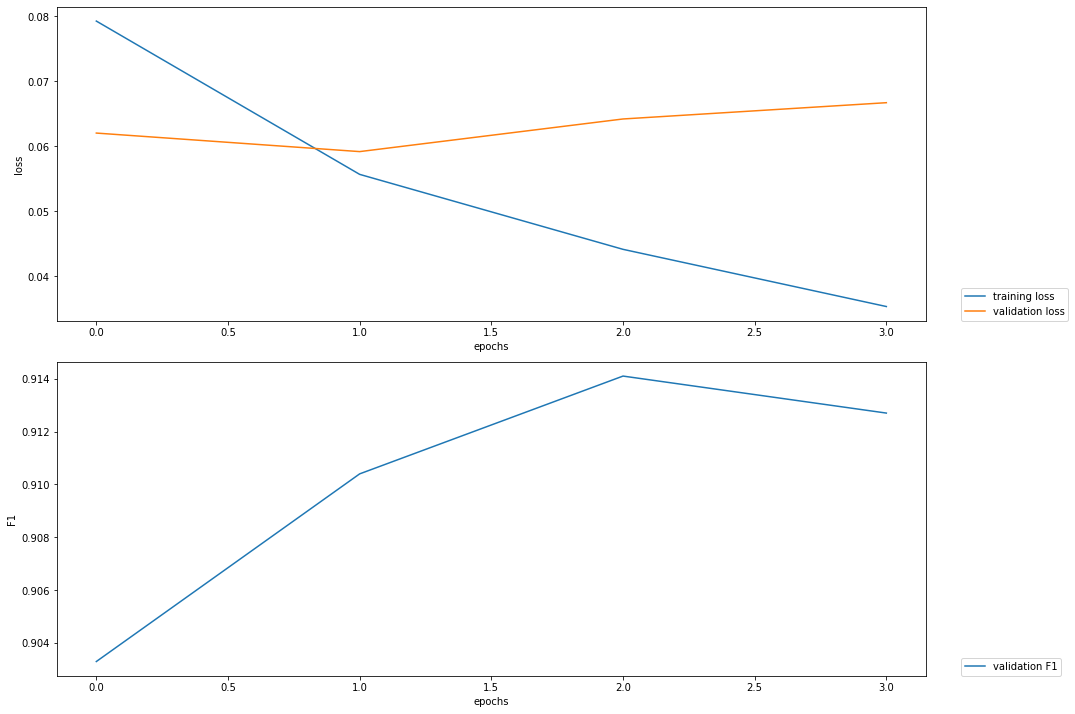

2022-08-24 19:09:46,457 Weights plots are saved in /content/drive/My Drive/team project/codes/models/flair_models/twitter_cyberbullying_distilroberta_maybe/weights.png


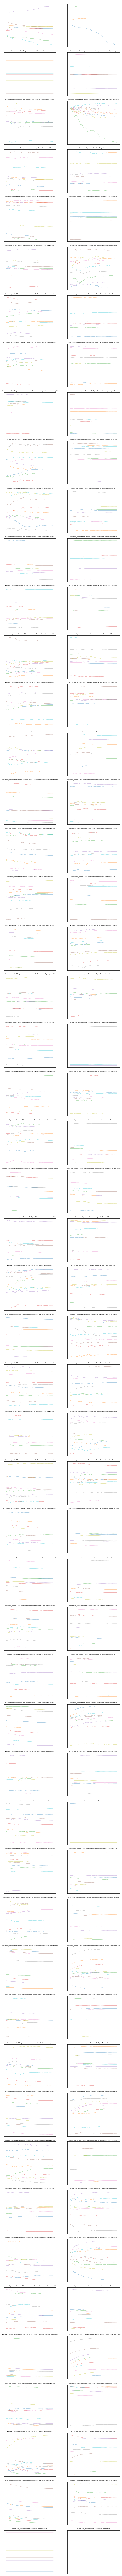

In [19]:
# visualize
plotter = Plotter()
plotter.plot_training_curves(path_model_distilroberta+'/loss.tsv')
plotter.plot_weights(path_model_distilroberta+'/weights.txt')

In [20]:
new_clf = TextClassifier.load(path_model_distilroberta+'/final-model.pt')

2022-08-24 19:09:49,754 loading file /content/drive/My Drive/team project/codes/models/flair_models/twitter_cyberbullying_distilroberta_maybe/final-model.pt


In [21]:
pred1 = Sentence("That girl is stupid")
pred2 = Sentence("This is a good material")

In [22]:
new_clf.predict(pred1)

In [23]:
pred1

Sentence: "That girl is stupid" → __label__1 (0.9975)

In [24]:
pred2

Sentence: "This is a good material"